In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import os
import SimpleITK as sitk

In [2]:
# 전처리

def read_mhd_image(file_path):
    mhd_file = sitk.ReadImage(file_path)
    image = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)
    return image

def read_and_process_files(image_dir, mask_dir, clip_range=(-1000, 1000), new_size=(128, 128, 64)):
    image_files = [file for file in os.listdir(image_dir) if file.endswith('.mhd')]
    
    images = []
    masks = []
    
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, image_file)
        
        image = read_mhd_image(image_path)
        mask = read_mhd_image(mask_path)
        
        # 데이터 클리핑
        np.clip(image, clip_range[0], clip_range[1], out=image)
        
        # 슬라이스 크기 조정
        resized_image = resize_image(image, new_size)
        resized_mask = resize_image(mask, new_size)
        
        images.append(resized_image)
        masks.append(resized_mask)
    
    return np.array(images), np.array(masks)

def resize_image(image, new_size):
    image_itk = sitk.GetImageFromArray(image)
    original_size = image_itk.GetSize()
    original_spacing = image_itk.GetSpacing()
    new_spacing = [original_spacing[i] * (original_size[i] / new_size[i]) for i in range(len(new_size))]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(new_spacing)
    resample.SetSize(new_size)
    resample.SetInterpolator(sitk.sitkLinear)
    resampled_image = resample.Execute(image_itk)
    return sitk.GetArrayFromImage(resampled_image)

def visualize_slices(image, num_slices=5, title='Image Slices'):
    total_slices = image.shape[0]
    step = total_slices // num_slices
    
    plt.figure(figsize=(15, 5))
    for i in range(num_slices):
        plt.subplot(1, num_slices, i + 1)
        plt.imshow(image[i * step], cmap='gray')
        plt.title(f'Slice {i * step}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [3]:
# 데이터 디렉토리
positive_image_directory = "C:/Users/Taeho/Downloads/lung_cancer_project/data/subset1/positive"
positive_mask_directory = "C:/Users/Taeho/Downloads/lung_cancer_project/data/seg-lungs-LUNA16/positive_mask"
negative_image_directory = "C:/Users/Taeho/Downloads/lung_cancer_project/data/subset1/negative"
negative_mask_directory = "C:/Users/Taeho/Downloads/lung_cancer_project/data/seg-lungs-LUNA16/negative_mask"

In [4]:
positive_images, positive_masks = read_and_process_files(positive_image_directory, positive_mask_directory)

In [5]:
negative_images, negative_masks = read_and_process_files(negative_image_directory, negative_mask_directory)

In [6]:
# 데이터셋 병합
images = np.concatenate((positive_images, negative_images), axis=0)
masks = np.concatenate((positive_masks, negative_masks), axis=0)

In [7]:
# 데이터셋을 훈련, 검증, 테스트 세트로 분할
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 데이터 차원 맞추기
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate

def unet_model(input_shape):
    inputs = Input(input_shape)
    
    # Contracting path
    c1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(p1)
    c2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
    
    c3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(p2)
    c3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
    
    c4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(p3)
    c4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling3D((2, 2, 2))(c4)
    
    c5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(p4)
    c5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(c5)
    
    # Expansive path
    u6 = UpSampling3D((2, 2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(u6)
    c6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(c6)
    
    u7 = UpSampling3D((2, 2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(u7)
    c7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(c7)
    
    u8 = UpSampling3D((2, 2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(u8)
    c8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c8)
    
    u9 = UpSampling3D((2, 2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(u9)
    c9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv3D(1, (1, 1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# 모델 생성
input_shape = (64, 128, 128, 1)
model = unet_model(input_shape)

# 모델 요약
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 64, 128, 128, 1)   │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d (Conv3D)               │ (None, 64, 128, 128, 32)  │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_1 (Conv3D)             │ (None, 64, 128, 128, 32)  │          27,680 │ conv3d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d (MaxPooling3D)  │ (None, 32, 64, 64, 32)    │               0 │ conv3d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_2 (Conv3D)             │ (None, 32, 64, 64, 64)    │          55,360 │ max_pooling3d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_3 (Conv3D)             │ (None, 32, 64, 64, 64)    │         110,656 │ conv3d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_1               │ (None, 16, 32, 32, 64)    │               0 │ conv3d_3[0][0]             │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_4 (Conv3D)             │ (None, 16, 32, 32, 128)   │         221,312 │ max_pooling3d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_5 (Conv3D)             │ (None, 16, 32, 32, 128)   │         442,496 │ conv3d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_2               │ (None, 8, 16, 16, 128)    │               0 │ conv3d_5[0][0]             │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_6 (Conv3D)             │ (None, 8, 16, 16, 256)    │         884,992 │ max_pooling3d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_7 (Conv3D)             │ (None, 8, 16, 16, 256)    │       1,769,728 │ conv3d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_3               │ (None, 4, 8, 8, 256)      │               0 │ conv3d_7[0][0]             │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_8 (Conv3D)             │ (None, 4, 8, 8, 512)      │       3,539,456 │ max_pooling3d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_9 (Conv3D)             │ (None, 4, 8, 8, 512)      │       7,078,400 │ conv3d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling3d (UpSampling3D)  │ (None, 8, 16, 16, 512)    │               

 Total params: 23,532,289 (89.77 MB)

 Trainable params: 23,532,289 (89.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 모델 훈련
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=4)

Epoch 1/10


In [48]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 44s 44s/step - accuracy: 0.3135 - loss: 6.2894
Test Loss: 6.289446830749512, Test Accuracy: 0.31349167227745056


In [43]:
# 훈련 결과 시각화
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

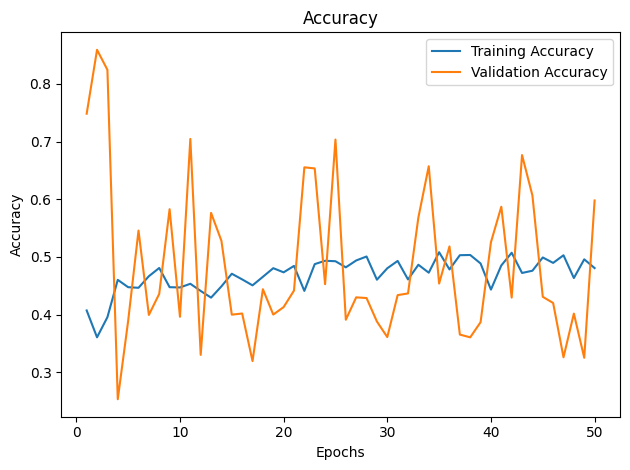

In [44]:
# Accuracy 그래프
# plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# 모델 평가 및 예측
y_pred_masks = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step


In [ ]:
# 이진분류

In [21]:
# 세그멘테이션된 폐 영역 추출
segmented_lungs = X_test * y_pred_masks

# 3D 데이터를 2D 데이터로 변환
def convert_3d_to_2d(data):
    num_samples = data.shape[0]
    num_slices = data.shape[1]
    height = data.shape[2]
    width = data.shape[3]
    
    data_2d = data.reshape(num_samples * num_slices, height, width, 1)
    return data_2d

segmented_lungs_2d = convert_3d_to_2d(segmented_lungs)


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

# CNN 모델 정의
def create_cnn(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (segmented_lungs_2d.shape[1], segmented_lungs_2d.shape[2], segmented_lungs_2d.shape[3])
cnn_model = create_cnn(input_shape)

# 데이터셋을 훈련, 검증, 테스트 세트로 분할
X_train, X_val, y_train, y_val = train_test_split(segmented_lungs_2d, np.repeat(test_labels, segmented_lungs.shape[1]), test_size=0.2, random_state=42)

C:\Users\Taeho\anaconda3\envs\lung_cancer\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NameError: name 'test_labels' is not defined

In [ ]:
# CNN 모델 학습
cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

In [ ]:
# 훈련 결과 시각화
import matplotlib.pyplot as plt

train_acc = cnn_model.history['accuracy']
val_acc = cnn_model.history['val_accuracy']
train_loss = cnn_model.history['loss']
val_loss = cnn_model.history['val_loss']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs. Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epochs vs. Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 모델 평가
test_loss, test_accuracy = cnn_model.evaluate(X_val, y_val)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

In [39]:
# 세그멘테이션된 폐 영역 추출 및 평균 계산
def get_segmented_lungs_mean(data, masks):
    segmented_lungs = data * masks
    segmented_lungs_mean = np.mean(segmented_lungs, axis=(1, 2, 3))
    return segmented_lungs_mean

# 테스트 데이터의 세그멘테이션된 폐 영역 평균 계산
segmented_lungs_mean = []
test_labels_mean = []
for i in range(len(test_generator)):
    X_batch, _ = test_generator[i]
    y_pred_batch = model.predict(X_batch)
    segmented_lungs_mean.append(get_segmented_lungs_mean(X_batch, y_pred_batch))
    test_labels_mean.extend([test_labels[i]] * X_batch.shape[0])  # 라벨을 반복 추가

segmented_lungs_mean = np.concatenate(segmented_lungs_mean, axis=0)
test_labels_mean = np.array(test_labels_mean)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split

# MLP 모델 정의
def create_mlp(input_shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 2D CNN 모델 정의
def create_cnn(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 데이터 모양 확인 및 변경
segmented_lungs_mean = segmented_lungs_mean.reshape(-1, 1)

# 이진 분류 모델 학습
input_shape = (segmented_lungs_mean.shape[1], )
mlp_model = create_mlp(input_shape)

# 데이터셋을 훈련, 검증, 테스트 세트로 분할
X_train, X_val, y_train, y_val = train_test_split(segmented_lungs_mean, test_labels_mean, test_size=0.2, random_state=42)

# MLP 모델 학습
mlp_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step - accuracy: 0.0000e+00 - loss: 10.7360 - val_accuracy: 0.0000e+00 - val_loss: 0.7028
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0000e+00 - loss: 0.7050 - val_accuracy: 1.0000 - val_loss: 6.0411e-04
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 1.3943e-04 - val_accuracy: 1.0000 - val_loss: 4.7813e-06
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 4.8330e-07 - val_accuracy: 1.0000 - val_loss: 1.0287e-07
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 6.3510e-09 - val_accuracy: 1.0000 - val_loss: 4.3460e-09
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 1.8753e-10 - val_accuracy: 1.0000 - val_loss: 2.9349e-10
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 9.4718e-12 - val_accuracy: 1.0000 - val_loss: 2.8081e-11
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000

In [41]:
# 모델 평가
test_loss, test_accuracy = mlp_model.evaluate(X_val, y_val)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.1450e-17
Test Loss: 1.144988284261515e-17, Test Accuracy: 1.0
